<a href="https://colab.research.google.com/github/Heity94/TWSM_Lab/blob/main/Project/Notebooks/MA_SimilarityComparison_Glove6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#set path to data in Google Drive
data_path = "/content/drive/MyDrive/2022_Analytics Lab Student Projects/Data/Topic 1/Data_Team1/SynDet"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
#import duckdb
#import sqlalchemy

#!pip install -U sentence-transformers
#from sentence_transformers import util

In [ ]:
nounphrases = pd.read_csv(data_path+"/SynDet_entities_train.csv")
nounphrases.head(10)

,Unnamed: 0,article_id,sentence_id,ent_id,noun_phrases,true_ent_id
0,0,188,188_3753_3772,videotex,which,0
1,1,188,188_3753_3772,videotex,we,0
2,2,188,188_3753_3772,videotex,an information,0
3,3,188,188_3753_3772,videotex,communication resource,0
4,4,188,188_3753_3772,videotex,the Minitel system,0
5,5,188,188_3828_3848,competitive advantage,It,0
6,6,188,188_3828_3848,competitive advantage,any rm,0
7,7,188,188_3828_3848,competitive advantage,the eld,0
8,8,188,188_3828_3848,competitive advantage,so competitive advantages,0
9,9,188,188_3848_3883,government,This,0


In [ ]:
# Filter for article 188
nounphrases_188 = nounphrases.loc[nounphrases["article_id"]==188]

In [ ]:
nounphrases_188['noun_phrases'] = nounphrases_188['noun_phrases'].astype(str)
nounphrases_188 = nounphrases_188.reset_index(drop=True)
nounphrases_188['noun_phrases']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0                         which
1                            we
2                an information
3        communication resource
4            the Minitel system
                 ...           
3222                       mind
3223          the French people
3224             the government
3225    the French superhighway
3226       The Minitel terminal
Name: noun_phrases, Length: 3227, dtype: object

In [ ]:
ontology_syn = pd.read_csv(data_path+"/SynDet_ontology_train.csv", index_col=0)
ontology_syn.shape

(340613, 4)

In [ ]:
# Check number of synonyms per entity_id
ent_sy_group = ontology_syn.groupby("entity_id")[["synonym"]].nunique().sort_values(by="synonym", ascending=False)
ent_sy_group

,synonym
entity_id,
individual participant,195173
survey,36130
three validities,13677
online learning system,8583
communication service infrastructure,7635
...,...
Hardy-Weinberg equilibrium testing,1
knowledge creation,1
commercial bank,1


In [ ]:
# Downsample entities with more than 100 synonyms to a 100 synoyms (but always include "main entity_id" in subsample)
idx = ent_sy_group[ent_sy_group["synonym"]>100].index.tolist()

dfs = []
for entity in idx:
  t1 = ontology_syn[(ontology_syn.entity_id==entity)&(ontology_syn.synonym==entity)]
  t2 = ontology_syn[(ontology_syn.entity_id==entity)&(ontology_syn.synonym!=entity)].sample(99)
  dfs.append(pd.concat([t1,t2]))
dfs.append(ontology_syn.loc[~ontology_syn["entity_id"].isin(idx)]) # Append dataframe for all entities with less then 100 synonyms to list

# Combine all dataframes 
ontology_syn_ds = pd.concat(dfs).reset_index(drop=True)

In [ ]:
#Show synonyms in ontology which appear in more than 1 entity
ontology_syn_ds[ontology_syn_ds.synonym.duplicated(keep=False)].sort_values(by="synonym")

,entity_id,category,label,synonym
22253,Pearson's Chi square test,methodological entity,ANALYSIS_METHOD,Chi2 test for independence
21871,Pearson's chi squared test of independence bet...,methodological entity,ANALYSIS_METHOD,Chi2 test for independence
22248,Pearson's Chi square test,methodological entity,ANALYSIS_METHOD,Chi2 test for independences
21865,Pearson's chi squared test of independence bet...,methodological entity,ANALYSIS_METHOD,Chi2 test for independences
25266,information technology operation,domain specific entity,TOPIC,EDP operation
...,...,...,...,...
3967,procurement information system,domain specific entity,TECHNOLOGY,web based procurements
29501,website,domain specific entity,TECHNOLOGY,web sites
29876,web application,domain specific entity,TECHNOLOGY,web sites
9872,Chi square metric,methodological entity,METRIC,χ 2S


In [ ]:
#List of unique entities from ontology with synonyms with downsampling

ontology_syn_ds_unique = ontology_syn_ds.drop_duplicates(subset="synonym")

In [ ]:
ontology_syn_ds_unique = ontology_syn_ds_unique.reset_index(drop=True)
ontology_syn_ds_unique["synonym"][3115]

'digital mediated collaboration'

In [ ]:
len(ontology_syn_ds_unique["synonym"])

32373

# Using Glove

## Create embedding for the noun phrases

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')


def create_corpus_tk(df):
    corpus = []
    for text in df:
        words = text.split()
        corpus.append(words)
    return corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Create a corpus, where each noun phrase is splited in individual words 
corpus_nounphrase = create_corpus_tk(nounphrases_188["noun_phrases"])

corpus_nounphrase[2]

['an', 'information']

In [ ]:
num_words_nounphrase = len(corpus_nounphrase)
num_words_nounphrase

3227

In [ ]:
# Tokenizing the words

from keras.preprocessing.text import Tokenizer

tokenizer_nounphrase = Tokenizer(num_words=num_words_nounphrase)
tokenizer_nounphrase.fit_on_texts(nounphrases_188["noun_phrases"])

nounphrase_sequences = tokenizer_nounphrase.texts_to_sequences(nounphrases_188["noun_phrases"])
nounphrase_sequences[2]

[21, 3]

In [ ]:
len(nounphrase_sequences)

3227

In [ ]:
len(nounphrases_188["noun_phrases"])

3227

In [ ]:
print(nounphrases_188["noun_phrases"][0])
print(nounphrase_sequences[0])

which
[26]


In [ ]:
word_index_nounphrase = tokenizer_nounphrase.word_index
print("Number of unique words:", len(word_index_nounphrase))

Number of unique words: 822


In [ ]:
# Create a dictionary of word embedding from Glove (6B tokens, 100D word vector)

embedding_dict = {}
model = "/content/drive/MyDrive/2022_Analytics Lab Student Projects/Data/Topic 1/Data_Team1/glove.6B.100d.txt"

with open(model, "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
f.close()

In [ ]:
# To assign the pre-trained Glove embedding to our word index (individual word)

def embedding_word(word_index):
  num_words = len(word_index) + 1
  embedding = np.zeros((num_words, 100))
  for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding[i] = emb_vec
  return embedding

In [ ]:
embedding_nounphrase_word = embedding_word(word_index_nounphrase)

In [ ]:
word_index_nounphrase["information"]

3

In [ ]:
(embedding_nounphrase_word[3] == embedding_dict.get("information")).all()

True

In [ ]:
# To create embedding for the nounphrases, where we get the average of the embeddings of all the individual words in that nounphrase 

def embedding(sequences, embedding_word):
  emb_list = []
  for v in sequences:
    v_list = []
    for index in v:
      v_list.append(embedding_word[index])
    emb_list.append(np.mean(v_list, axis=0))
  return emb_list

In [ ]:
embedding_nounphrase = embedding(nounphrase_sequences, embedding_nounphrase_word)
len(embedding_nounphrase)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3227

In [ ]:
len(nounphrase_sequences)

3227

In [ ]:
len(nounphrases_188)

3227

## Creating embedding for the entities

In [ ]:
corpus_entity = create_corpus_tk(ontology_syn_ds_unique["synonym"])

corpus_entity[0]

['individual', 'participant']

In [ ]:
num_words_entity = len(corpus_entity)
num_words_entity

32373

In [ ]:
tokenizer_entity = Tokenizer(num_words=num_words_entity)
tokenizer_entity.fit_on_texts(ontology_syn_ds_unique["synonym"])

entity_sequences = tokenizer_entity.texts_to_sequences(ontology_syn_ds_unique["synonym"])

In [ ]:
word_index_entity = tokenizer_entity.word_index
print("Number of unique words:", len(word_index_entity))

Number of unique words: 5476


In [ ]:
embedding_entity_word = embedding_word(word_index_entity)

In [ ]:
embedding_entity = embedding(entity_sequences, embedding_entity_word)

# Cosine similarity using for loop

In [ ]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Computing the cosine similarity of each noun phrase with each of the synonym and take the highest score
def computing_cosine(embedding_nounphrase, embedding_entity, df_nounphrase, df_entity): 
  df = pd.DataFrame(columns=['cosine', 'nounphrase_id', 'nounphrase', 'entity_id', 'entity'])
  for i1, np in enumerate(embedding_nounphrase): 
    df2 = pd.DataFrame(columns=['cosine', 'nounphrase_id', 'nounphrase', 'entity_id', 'entity'])
    for i2, e in enumerate(embedding_entity): 
      cosine = cosine_similarity(np.reshape(1,-1), e.reshape(1,-1))
      a = pd.Series([cosine, i1, df_nounphrase[i1], i2, df_entity[i2]], index=df2.columns)
      df2 = df2.append(a, ignore_index=True)
    max = df2.sort_values(by=['cosine'], ascending=False).head(1)
    df = df.append(max, ignore_index=True)
    
  return df

In [ ]:
test_np = embedding_nounphrase[:10]
test_entity = embedding_entity[:20]
len(test_np)

10

In [ ]:
test = computing_cosine(test_np, test_entity, nounphrases_188["noun_phrases"], ontology_syn_ds_unique["synonym"])
test

,cosine,nounphrase_id,nounphrase,entity_id,entity
0,[[0.8407925151644017]],0,which,1,IS and security IT assistants
1,[[0.789508651033507]],1,we,1,IS and security IT assistants
2,[[0.851141980965083]],2,an information,16,information and junior IS citizens
3,[[0.7447829682158479]],3,communication resource,2,usable and knowledge research analysts
4,[[0.7302238893649966]],4,the Minitel system,19,IT and multicultural security analysts
5,[[0.8653399079222501]],5,It,1,IS and security IT assistants
6,[[0.6329602596148854]],6,any rm,6,usable and IS senior individual
7,[[0.6168540336507342]],7,the eld,6,usable and IS senior individual
8,[[0.778325166374529]],8,so competitive advantages,3,professional and financial usable bidders
9,[[0.8493736394710465]],9,This,1,IS and security IT assistants


In [ ]:
cosine_table = computing_cosine(embedding_nounphrase, embedding_entity, nounphrases_188["noun_phrases"], ontology_syn_ds_unique["synonym"])
cosine_table

# Cosine Similarty using util.semanticsearch 

In [ ]:
import tensorflow as tf

!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer, util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.2 MB/s 
     |████████████████████████████████| 4.4 MB 29.3 MB/s 
     |████████████████████████████████| 1.2 MB 51.1 MB/s 
     |████████████████████████████████| 101 kB 15.1 MB/s 
     |████████████████████████████████| 596 kB 73.8 MB/s 
     |████████████████████████████████| 6.6 MB 44.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=fd4bc11235bd51c45644190e2ee71e9a8b58735e6ac13d08ff1d233fee09c554
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Create a function to convert the np array list of embedding to Pytorch tensor 
def to_pytorch_tensor(embedding):
  list = []
  empty = []
  for idx, i in enumerate(embedding):
    if i.shape != (100,): 
      empty.append(idx)
    else:
      embedding_tensor = torch.as_tensor(i)
      list.append(embedding_tensor)
  return torch.stack(list), empty

In [ ]:
embedding_nounphrase_tensor, empty_nounphrases = to_pytorch_tensor(embedding_nounphrase)
embedding_nounphrase_tensor.shape

torch.Size([3213, 100])

In [ ]:
# Check if there are any empty noun phrase embedding
empty_nounphrases

[379, 386, 393, 688, 702, 992, 1021, 1612, 1622, 1852, 1926, 2871, 2883, 3049]

In [ ]:
# Dropping the rows with empty noun phrases
for i in empty_nounphrases:
  nounphrases_188 = nounphrases_188.drop([nounphrases_188.index[i]])

In [ ]:
len(nounphrases_188)

3213

In [ ]:
embedding_entity_tensor, empty = to_pytorch_tensor(embedding_entity)
embedding_entity_tensor.shape

torch.Size([32373, 100])

In [ ]:
# Checking if there is any empty entity embedding
empty

[]

In [ ]:
cosine_scores = util.semantic_search(embedding_nounphrase_tensor, embedding_entity_tensor, top_k=1)
#cosine_scores

In [ ]:
  dfs = []
  for idx, sim in enumerate(cosine_scores):
    test = pd.DataFrame(sim)
    test["sentence_id"] = nounphrases_188.iloc[idx,2]
    test["noun_phrase_txt"] = nounphrases_188.iloc[idx,4]
    test = test.rename(columns={"corpus_id":"entity_id"})
    dfs.append(test)

In [ ]:
dfs_df = pd.concat(dfs)
dfs_df = dfs_df[["score", "sentence_id", "noun_phrase_txt", "entity_id"]] # reorder columns
dfs_df[["main_entity_id"]] = dfs_df[["entity_id"]].applymap(lambda x:  ontology_syn_ds_unique.iloc[x,0])
dfs_df[["entity_id"]] = dfs_df[["entity_id"]].applymap(lambda x:  ontology_syn_ds_unique.iloc[x,3])
dfs_df = dfs_df.sort_values(by="score", ascending=False, ignore_index=True) # sort by score and reset index

dfs_df

,score,sentence_id,noun_phrase_txt,entity_id,main_entity_id
0,1.0,188_3349_3371,services,ridehailing services,ride sharing platform
1,1.0,188_9906_9948,services,ridehailing services,ride sharing platform
2,1.0,188_2610_2634,services,ridehailing services,ride sharing platform
3,1.0,188_3613_3675,services,ridehailing services,ride sharing platform
4,1.0,188_10441_10500,services,ridehailing services,ride sharing platform
...,...,...,...,...,...
3208,0.0,188_5860_5898,Steinmueller,individual participant,individual participant
3209,0.0,188_830_1213,Quélin,individual participant,individual participant
3210,0.0,188_830_1213,Ghertman,individual participant,individual participant
3211,0.0,188_830_1213,Quélin,individual participant,individual participant


In [ ]:
# Merge sim scores on entities sample to get "true" entity id
sim_scores_sample_mapped = dfs_df.merge(nounphrases_188[["sentence_id", "noun_phrases", "true_ent_id"]],
                                               how="left", left_on=["sentence_id", "noun_phrase_txt"], 
                                               right_on=["sentence_id", "noun_phrases"])\
                                               .drop(columns=["noun_phrases"])

In [ ]:
# Define columns which should be checked for duplicates
col_dupl = sim_scores_sample_mapped.columns[1:].to_list()

#Drop duplicates
sim_scores_sample_mapped = sim_scores_sample_mapped.drop_duplicates(subset=col_dupl)

In [ ]:
#Merge sim scores again on entities sample to get "true" entity id, but this time with the true entity id which was found by Roland
sim_scores_sample_mapped_f =sim_scores_sample_mapped.merge(nounphrases_188[["sentence_id", "ent_id"]], 
                                                           how="left", left_on=["sentence_id", "main_entity_id"], 
                                                           right_on=["sentence_id", "ent_id"])\
                                                           .rename(columns={"ent_id":"true_ent_id_cmpl_sen"})\
                                                           .drop_duplicates()

In [ ]:
# Define function to combine both columns "true_ent_id" & "true_ent_id_cmpl_sen"
def true_ent_label(x):

  if x.true_ent_id!="0":
    return x.true_ent_id
  else:
    return x.true_ent_id_cmpl_sen

In [ ]:
# Compare both columns and store correct value  in column true_entity_id
sim_scores_sample_mapped_f["true_entity_id"] = sim_scores_sample_mapped_f.apply(lambda x: true_ent_label(x), 
                                                                                axis=1, result_type="expand")

#Fill all NaN Values with 0 (no match)
sim_scores_sample_mapped_f["true_entity_id"] = sim_scores_sample_mapped_f["true_entity_id"].fillna(0)

#Drop columns "true_ent_id" & "true_ent_id_cmpl_sen"
sim_scores_sample_mapped_f = sim_scores_sample_mapped_f.drop(columns=["true_ent_id", "true_ent_id_cmpl_sen"])

In [ ]:
sim_scores_sample_mapped_f.head(10)

,score,sentence_id,noun_phrase_txt,entity_id,main_entity_id,true_entity_id
0,1.0,188_3349_3371,services,ridehailing services,ride sharing platform,0
1,1.0,188_9906_9948,services,ridehailing services,ride sharing platform,0
2,1.0,188_2610_2634,services,ridehailing services,ride sharing platform,0
3,1.0,188_3613_3675,services,ridehailing services,ride sharing platform,0
4,1.0,188_10441_10500,services,ridehailing services,ride sharing platform,0
5,1.0,188_167_285,services,ridehailing services,ride sharing platform,0
6,1.0,188_5200_5225,services,ridehailing services,ride sharing platform,0
7,1.0,188_5256_5285,services,ridehailing services,ride sharing platform,0
8,1.0,188_8287_8342,services,ridehailing services,ride sharing platform,0
9,1.0,188_4241_4286,services,ridehailing services,ride sharing platform,0


In [ ]:
# Check wheter main_entity based on cosine similarity is identical to "true" main entity label 
sim_scores_sample_mapped_f["correct_match"] = sim_scores_sample_mapped_f.main_entity_id==sim_scores_sample_mapped_f.true_entity_id

In [ ]:
sim_scores_sample_mapped_f.head(3)

,score,sentence_id,noun_phrase_txt,entity_id,main_entity_id,true_entity_id,correct_match
0,1.0,188_3349_3371,services,ridehailing services,ride sharing platform,0,False
1,1.0,188_9906_9948,services,ridehailing services,ride sharing platform,0,False
2,1.0,188_2610_2634,services,ridehailing services,ride sharing platform,0,False


In [ ]:
# Check results for one sample sentence
sim_scores_sample_mapped_f[(sim_scores_sample_mapped_f.sentence_id=="188_5984_6028")].sort_values(by="score", ascending=False)

,score,sentence_id,noun_phrase_txt,entity_id,main_entity_id,true_entity_id,correct_match
137,1.000000,188_5984_6028,application,application productivenesses,IT productivity,0,False
291,1.000000,188_5984_6028,information infrastructure,information infrastructure,information technology infrastructure,information technology infrastructure,True
447,0.958562,188_5984_6028,service development,information service development,information services development,0,False
570,0.940639,188_5984_6028,the private sector,private sector,private sector,private sector,True
742,0.937718,188_5984_6028,the development,IT development agilities,IS development agility,0,False
1031,0.918924,188_5984_6028,the public institutions,IT service institutions,IT service provider,0,False
2187,0.895045,188_5984_6028,innovative communications,collaborative information communications techn...,computer supported cooperative work,0,False
2627,0.881901,188_5984_6028,an information superhighway,information superhighway,information superhighway,information superhighway,True
3278,0.848460,188_5984_6028,a 'host,build a theory,theory development,0,False
3545,0.798061,188_5984_6028,hardware receivers,hardware,hardware,hardware,True


In [ ]:
# Create bins of similarity score to check the number of correct matches compared to the labels of the database
grouped_df = sim_scores_sample_mapped_f.groupby(pd.cut(sim_scores_sample_mapped_f.score, np.arange(0.,1.1,0.1)))[["correct_match"]]
corr_match_bins = np.round(grouped_df.sum()/grouped_df.count(),2).rename(columns={"correct_match":"pct_correct_in_bin"})
corr_match_bins["no_correct"]= grouped_df.sum()
corr_match_bins["total"]= grouped_df.count()
corr_match_bins = corr_match_bins[["total", "no_correct", "pct_correct_in_bin"]]
corr_match_bins = corr_match_bins.iloc[::-1] #reverse order

In [ ]:
corr_match_bins

,total,no_correct,pct_correct_in_bin
score,,,
"(0.9, 1.0]",482,92,0.19
"(0.8, 0.9]",638,62,0.10
"(0.7, 0.8]",168,12,0.07
"(0.6, 0.7]",95,0,0.00
"(0.5, 0.6]",51,1,0.02
"(0.4, 0.5]",30,0,0.00
"(0.3, 0.4]",20,0,0.00
"(0.2, 0.3]",0,0,NaN
"(0.1, 0.2]",0,0,NaN


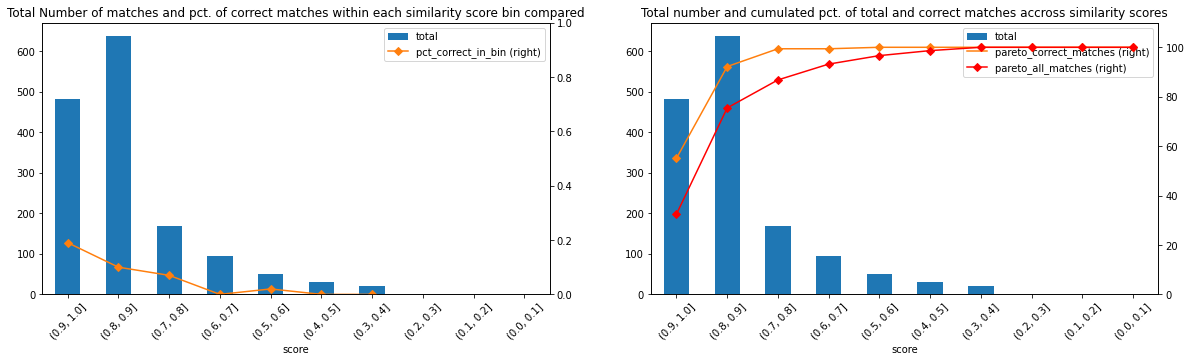

In [ ]:
#corr_match_bins = corr_match_bins.iloc[::-1]
corr_match_bins['pareto_correct_matches'] = 100 *corr_match_bins.no_correct.cumsum() / corr_match_bins.no_correct.sum()
corr_match_bins['pareto_all_matches'] = 100 *corr_match_bins.total.cumsum() / corr_match_bins.total.sum()
fig, axes = plt.subplots(1,2, figsize=(20,5))


#First plot
ax01 = corr_match_bins.plot(use_index=True, y='total',  kind='bar', ax=axes[0])
ax02 = corr_match_bins.plot(use_index=True, y='pct_correct_in_bin', marker='D', color="C1", kind='line', ax=axes[0], secondary_y=True)
#ax1.invert_xaxis()
for tick in ax01.get_xticklabels():
    tick.set_rotation(45)
#ax2.invert_xaxis()
ax02.set_ylim([0,1]);
axes[0].set_title("Total Number of matches and pct. of correct matches within each similarity score bin compared");


# First plot
ax1 = corr_match_bins.plot(use_index=True, y='total',  kind='bar', ax=axes[1])
ax2 = corr_match_bins.plot(use_index=True, y='pareto_correct_matches', marker='D', color="C1", kind='line', ax=axes[1], secondary_y=True)
ax4 = corr_match_bins.plot(use_index=True, y='pareto_all_matches', marker='D', color="red", kind='line', ax=axes[1], secondary_y=True)
axes[1].set_title("Total number and cumulated pct. of total and correct matches accross similarity scores");
#ax1.invert_xaxis()
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
#ax2.invert_xaxis()
ax2.set_ylim([0,110]);